<a href="https://www.kaggle.com/code/shoaibrkhan/data-expedition-movies?scriptVersionId=145310678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import re
from ast import literal_eval

import warnings

warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/netflix-tv-shows-and-movies/credits.csv
/kaggle/input/netflix-tv-shows-and-movies/titles.csv
/kaggle/input/movies-dataset-for-feature-extracion-prediction/movies.csv
/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv


In [2]:
movies = pd.read_csv("/kaggle/input/movies-dataset-for-feature-extracion-prediction/movies.csv")
df = pd.DataFrame(movies)
print(movies.shape)
df

(9999, 9)


,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9994,The Imperfects,(2021– ),"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n \n Stars:\nMorgan Taylor Camp...,NaN,NaN,NaN
9995,Arcane,(2021– ),"\nAnimation, Action, Adventure",NaN,\nAdd a Plot\n,\n,NaN,NaN,NaN
9996,Heart of Invictus,(2022– ),"\nDocumentary, Sport",NaN,\nAdd a Plot\n,\n Director:\nOrlando von Einsiedel\n| \n ...,NaN,NaN,NaN
9997,The Imperfects,(2021– ),"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n Director:\nJovanka Vuckovic\n| \n Sta...,NaN,NaN,NaN


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   object 
 1   YEAR      9355 non-null   object 
 2   GENRE     9919 non-null   object 
 3   RATING    8179 non-null   float64
 4   ONE-LINE  9999 non-null   object 
 5   STARS     9999 non-null   object 
 6   VOTES     8179 non-null   object 
 7   RunTime   7041 non-null   float64
 8   Gross     460 non-null    object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [4]:
movies.isnull().sum()

MOVIES         0
YEAR         644
GENRE         80
RATING      1820
ONE-LINE       0
STARS          0
VOTES       1820
RunTime     2958
Gross       9539
dtype: int64

# Feature Extraction

In [5]:
# As we can see the Gross column only have 460 non null values from 9539
df.drop('Gross', axis=1, inplace=True)

### Check For Duplicate Movies

In [6]:
df['MOVIES'] = df['MOVIES'].str.strip()
duplicates = df[df.duplicated(subset=['MOVIES'], keep=False)]
duplicates

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0
5,Outer Banks,(2020– ),"\nAction, Crime, Drama",7.6,\nA group of teenagers from the wrong side of ...,"\n \n Stars:\nChase Stokes, \nMa...","25,858",50.0
7,Dexter,(2006–2013),"\nCrime, Drama, Mystery",8.6,"\nBy day, mild-mannered Dexter is a blood-spat...","\n \n Stars:\nMichael C. Hall, \...","665,387",53.0
8,Never Have I Ever,(2020– ),\nComedy,7.9,\nThe complicated life of a modern-day first g...,\n \n Stars:\nMaitreyi Ramakrish...,"34,530",30.0
...,...,...,...,...,...,...,...,...
9994,The Imperfects,(2021– ),"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n \n Stars:\nMorgan Taylor Camp...,NaN,NaN
9995,Arcane,(2021– ),"\nAnimation, Action, Adventure",NaN,\nAdd a Plot\n,\n,NaN,NaN
9996,Heart of Invictus,(2022– ),"\nDocumentary, Sport",NaN,\nAdd a Plot\n,\n Director:\nOrlando von Einsiedel\n| \n ...,NaN,NaN
9997,The Imperfects,(2021– ),"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n Director:\nJovanka Vuckovic\n| \n Sta...,NaN,NaN


In [7]:
unique_movies_from_duplicates = duplicates['MOVIES'].unique()
count_unique_movies_from_duplicates = len(unique_movies_from_duplicates)
count_unique_movies_from_duplicates

455

In [8]:
duplicates_count = df.duplicated(subset=['MOVIES']).sum()
print(f'Total duplicates: {duplicates_count}')

Total duplicates: 3576


### Removing Duplicates

In [9]:
#as we mentioned above, our movies data got so many duplicate movies, we will remove them
# movies_df = movies_df.sort_values(by=['RunTime', 'YEAR'], na_position='last')
# movies_df = movies_df.drop_duplicates(subset=['MOVIES'], keep='first')

# Identifying rows with non-null values in 'YEAR' or 'RunTime'
mask_non_null = ~df[['RunTime', 'YEAR']].isna().all(axis=1)

# Keeping the first occurrence of each movie title, but prioritize rows with non-null values
df = df.sort_values(by=['YEAR', 'RunTime'], na_position='last')
movies_df = df[~df.duplicated(subset=['MOVIES'], keep='first') & mask_non_null]

movies_df = movies_df.reset_index(drop=True)
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime
0,Söderkåkar,(1932),\nComedy,5.3,\nThe movie version of Gideon Wahlbergs comedy...,\n Director:\nWeyler Hildebrand\n| \n St...,59,87.0
1,Scarface,(1932),"\nAction, Crime, Drama",7.8,\nAn ambitious and nearly insane violent gangs...,"\n Directors:\nHoward Hawks, \nRichard Ross...","26,365",93.0
2,Kära släkten,(1933),\nComedy,5.4,\nThe story about a Stockholm wholesaler and h...,\n Director:\nGustaf Molander\n| \n Star...,36,94.0
3,Karriär,(1938),\nDrama,5.2,\nA traveling theater company in Sweden. Confl...,\n Director:\nSchamyl Bauman\n| \n Stars...,52,106.0
4,Dumbo,(1941),"\nAnimation, Adventure, Drama",7.2,"\nRidiculed because of his enormous ears, a yo...","\n Directors:\nSamuel Armstrong, \nNorman F...","124,409",64.0
...,...,...,...,...,...,...,...,...
6004,Kaos,NaN,"\nComedy, Drama, Fantasy",NaN,\nA modern day contemporary retelling of Greek...,\n,NaN,60.0
6005,Cuckoo Song,NaN,"\nDrama, Horror, Mystery",NaN,"\nIn the haunting aftermath of war, a missing ...",\n,NaN,60.0
6006,Open 24/7,NaN,\nDrama,NaN,\nTake a look into the lives of six people who...,\n,NaN,60.0
6007,Archive 81,NaN,"\nDrama, Horror, Sci-Fi",NaN,\nAdd a Plot\n,"\n Directors:\nRebecca Thomas, \nJames Wan\...",NaN,60.0


In [10]:
# now we will do feature Extraction, clean the features in columns that include '\n'
movies_df['GENRE'] = movies_df['GENRE'].str.replace('\n', '')
movies_df['ONE-LINE'] = movies_df['ONE-LINE'].str.replace('\n', '')
movies_df['STARS'] = movies_df['STARS'].str.strip()
movies_df['STARS'] = movies_df['STARS'].str.replace('\n', '')
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime
0,Söderkåkar,(1932),Comedy,5.3,The movie version of Gideon Wahlbergs comedy a...,Director:Weyler Hildebrand| Stars:Gideon W...,59,87.0
1,Scarface,(1932),"Action, Crime, Drama",7.8,An ambitious and nearly insane violent gangste...,"Directors:Howard Hawks, Richard Rosson| St...","26,365",93.0
2,Kära släkten,(1933),Comedy,5.4,The story about a Stockholm wholesaler and his...,Director:Gustaf Molander| Stars:Gösta Ekma...,36,94.0
3,Karriär,(1938),Drama,5.2,A traveling theater company in Sweden. Conflic...,Director:Schamyl Bauman| Stars:Signe Hasso...,52,106.0
4,Dumbo,(1941),"Animation, Adventure, Drama",7.2,"Ridiculed because of his enormous ears, a youn...","Directors:Samuel Armstrong, Norman Ferguson, W...","124,409",64.0
...,...,...,...,...,...,...,...,...
6004,Kaos,NaN,"Comedy, Drama, Fantasy",NaN,A modern day contemporary retelling of Greek m...,,NaN,60.0
6005,Cuckoo Song,NaN,"Drama, Horror, Mystery",NaN,"In the haunting aftermath of war, a missing gi...",,NaN,60.0
6006,Open 24/7,NaN,Drama,NaN,Take a look into the lives of six people who w...,,NaN,60.0
6007,Archive 81,NaN,"Drama, Horror, Sci-Fi",NaN,Add a Plot,"Directors:Rebecca Thomas, James Wan| Stars...",NaN,60.0


In [11]:
#as we can see our STARS column have both Director and Stars, now we'll split them in separate columns
def extract_names(row):
    directors = ', '.join(re.findall(r'Director[s]*:\s*([^|]+)', row))
    stars = ', '.join(re.findall(r'Stars*:\s*([^|]+)', row))
    return directors, stars

# Applying the function to create separate columns
movies_df[['DIRECTOR', 'STARS']] = movies_df['STARS'].apply(extract_names).apply(pd.Series)

movies_df['DIRECTOR'] = movies_df['DIRECTOR'].str.strip()
movies_df['STARS'] = movies_df['STARS'].str.strip()

movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR
0,Söderkåkar,(1932),Comedy,5.3,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59,87.0,Weyler Hildebrand
1,Scarface,(1932),"Action, Crime, Drama",7.8,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...","26,365",93.0,"Howard Hawks, Richard Rosson"
2,Kära släkten,(1933),Comedy,5.4,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36,94.0,Gustaf Molander
3,Karriär,(1938),Drama,5.2,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52,106.0,Schamyl Bauman
4,Dumbo,(1941),"Animation, Adventure, Drama",7.2,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...","124,409",64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac..."
...,...,...,...,...,...,...,...,...,...
6004,Kaos,NaN,"Comedy, Drama, Fantasy",NaN,A modern day contemporary retelling of Greek m...,,NaN,60.0,
6005,Cuckoo Song,NaN,"Drama, Horror, Mystery",NaN,"In the haunting aftermath of war, a missing gi...",,NaN,60.0,
6006,Open 24/7,NaN,Drama,NaN,Take a look into the lives of six people who w...,,NaN,60.0,
6007,Archive 81,NaN,"Drama, Horror, Sci-Fi",NaN,Add a Plot,"Evan Jonigkeit, Dina Shihabi, Matt McGorry, Ma...",NaN,60.0,"Rebecca Thomas, James Wan"


In [12]:
#Now we will be extracting text of STARS and Directors
movies_df['DIRECTOR'] = movies_df['DIRECTOR'].str.replace('Director:', '')
movies_df['DIRECTOR'] = movies_df['DIRECTOR'].str.replace('Directors:', '')
movies_df['STARS'] = movies_df['STARS'].str.replace('Stars:', '')

movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR
0,Söderkåkar,(1932),Comedy,5.3,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59,87.0,Weyler Hildebrand
1,Scarface,(1932),"Action, Crime, Drama",7.8,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...","26,365",93.0,"Howard Hawks, Richard Rosson"
2,Kära släkten,(1933),Comedy,5.4,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36,94.0,Gustaf Molander
3,Karriär,(1938),Drama,5.2,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52,106.0,Schamyl Bauman
4,Dumbo,(1941),"Animation, Adventure, Drama",7.2,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...","124,409",64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac..."
...,...,...,...,...,...,...,...,...,...
6004,Kaos,NaN,"Comedy, Drama, Fantasy",NaN,A modern day contemporary retelling of Greek m...,,NaN,60.0,
6005,Cuckoo Song,NaN,"Drama, Horror, Mystery",NaN,"In the haunting aftermath of war, a missing gi...",,NaN,60.0,
6006,Open 24/7,NaN,Drama,NaN,Take a look into the lives of six people who w...,,NaN,60.0,
6007,Archive 81,NaN,"Drama, Horror, Sci-Fi",NaN,Add a Plot,"Evan Jonigkeit, Dina Shihabi, Matt McGorry, Ma...",NaN,60.0,"Rebecca Thomas, James Wan"


In [13]:
movies_df.isnull().sum()

MOVIES        0
YEAR         19
GENRE        34
RATING      498
ONE-LINE      0
STARS         0
VOTES       498
RunTime     889
DIRECTOR      0
dtype: int64

### Handling missing values in Votes and Rating with Grouping Director's mean

In [14]:
# df['VOTES'] = pd.to_numeric(df['VOTES'], errors='coerce')
movies_df['VOTES'] = movies_df['VOTES'].str.replace(',', '').astype(float)

mean_ratings = movies_df.groupby('DIRECTOR')['RATING'].transform('mean')
mean_votes = movies_df.groupby('DIRECTOR')['VOTES'].transform('mean')

# Fill missing values in 'RATING' and 'VOTES' columns
movies_df['RATING'].fillna(mean_ratings, inplace=True)
movies_df['VOTES'].fillna(mean_votes, inplace=True)

# Convert 'VOTES' column to float and round
movies_df['VOTES'] = movies_df['VOTES'].round().astype(float)
movies_df['RATING'] = movies_df['RATING'].round().astype(float)

movies_df.isnull().sum()

MOVIES        0
YEAR         19
GENRE        34
RATING      193
ONE-LINE      0
STARS         0
VOTES       193
RunTime     889
DIRECTOR      0
dtype: int64

#### We can add some other dataset related to this one so we can match them with the movies name and fill the missing years as we cannot remove them

In [15]:
movies_df[pd.isna(movies_df['YEAR'])]

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR
5990,Little Baby Bum: Music Time,NaN,"Animation, Comedy, Family",7.0,"The world of exploration through rhythms, soun...",,17568.0,7.0,
5991,El tiempo que te doy,NaN,"Comedy, Drama, Romance",7.0,A woman tries to move on with her life after b...,"Álvaro Cervantes, Nadia de Santiago, Moussa Ec...",17568.0,10.0,
5992,Ídolo,NaN,"Comedy, Drama, Music",7.0,An unconditional fan starts impersonating his ...,Roger Gual,17568.0,10.0,
5993,Man vs. Bee,NaN,Comedy,NaN,Add a Plot,,NaN,10.0,David Kerr
5994,Karma's World,NaN,"Animation, Short, Comedy",7.0,A coming-of-age story about a young black girl...,,17568.0,11.0,
5995,Untitled to All the Boys Spinoff,NaN,"Comedy, Drama, Romance",7.0,"Kitty, the youngest of the Covey sisters, on h...",Anna Cathcart,17568.0,30.0,
5996,Baby Reindeer,NaN,"Biography, Drama",7.0,"Based on a compelling true story, the hit 2019...",Richard Gadd,17568.0,30.0,
5997,Wings of Fire,NaN,"Animation, Action, Adventure",7.0,A group of five young dragons who are prophesi...,,17568.0,40.0,
5998,One Piece,NaN,"Action, Adventure, Fantasy",7.0,A boy named Monkey D. Luffy embarks on a journ...,,17568.0,41.0,
5999,Lost Ollie,NaN,"Animation, Adventure, Drama",7.0,"A lost toy, searching across the countryside f...","Mary J. Blige, Jonathan Groff, Jake Johnson, T...",17568.0,45.0,


In [16]:
imdb_movies = pd.read_csv("/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv")
imdb_df = pd.DataFrame(imdb_movies)
print(imdb_movies.shape)
imdb_movies.head()

(1000, 16)


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [17]:
#the good thing is that, this data got 1000 movies as well and 1000 non null values in Released Year
#let's see how this dataset can help us
imdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [18]:
#removing start and end spaces for movies in both dataset
movies_df['MOVIES'] = movies_df['MOVIES'].str.strip()
imdb_df['Series_Title'] = imdb_df['Series_Title'].str.strip()

In [19]:
movies_df = pd.merge(movies_df, imdb_df[['Series_Title', 'Released_Year', 'Runtime', 'Genre', 'IMDB_Rating', 'No_of_Votes']], left_on='MOVIES', right_on='Series_Title', how='left')
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,No_of_Votes
0,Söderkåkar,(1932),Comedy,5.0,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59.0,87.0,Weyler Hildebrand,NaN,NaN,NaN,NaN,NaN,NaN
1,Scarface,(1932),"Action, Crime, Drama",8.0,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365.0,93.0,"Howard Hawks, Richard Rosson",Scarface,1983,170 min,"Crime, Drama",8.3,740911.0
2,Kära släkten,(1933),Comedy,5.0,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36.0,94.0,Gustaf Molander,NaN,NaN,NaN,NaN,NaN,NaN
3,Karriär,(1938),Drama,5.0,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52.0,106.0,Schamyl Bauman,NaN,NaN,NaN,NaN,NaN,NaN
4,Dumbo,(1941),"Animation, Adventure, Drama",7.0,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409.0,64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004,Kaos,NaN,"Comedy, Drama, Fantasy",7.0,A modern day contemporary retelling of Greek m...,,17568.0,60.0,,NaN,NaN,NaN,NaN,NaN,NaN
6005,Cuckoo Song,NaN,"Drama, Horror, Mystery",7.0,"In the haunting aftermath of war, a missing gi...",,17568.0,60.0,,NaN,NaN,NaN,NaN,NaN,NaN
6006,Open 24/7,NaN,Drama,7.0,Take a look into the lives of six people who w...,,17568.0,60.0,,NaN,NaN,NaN,NaN,NaN,NaN
6007,Archive 81,NaN,"Drama, Horror, Sci-Fi",NaN,Add a Plot,"Evan Jonigkeit, Dina Shihabi, Matt McGorry, Ma...",NaN,60.0,"Rebecca Thomas, James Wan",NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#removing min from Runtime col
movies_df['Runtime'] = movies_df['Runtime'].str.replace(' min', '')
movies_df

# genre_info = movies_df[(movies_df['Genre'].notna()) & (movies_df['GENRE'].isna())]
# genre_info

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,No_of_Votes
0,Söderkåkar,(1932),Comedy,5.0,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59.0,87.0,Weyler Hildebrand,NaN,NaN,NaN,NaN,NaN,NaN
1,Scarface,(1932),"Action, Crime, Drama",8.0,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365.0,93.0,"Howard Hawks, Richard Rosson",Scarface,1983,170,"Crime, Drama",8.3,740911.0
2,Kära släkten,(1933),Comedy,5.0,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36.0,94.0,Gustaf Molander,NaN,NaN,NaN,NaN,NaN,NaN
3,Karriär,(1938),Drama,5.0,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52.0,106.0,Schamyl Bauman,NaN,NaN,NaN,NaN,NaN,NaN
4,Dumbo,(1941),"Animation, Adventure, Drama",7.0,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409.0,64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004,Kaos,NaN,"Comedy, Drama, Fantasy",7.0,A modern day contemporary retelling of Greek m...,,17568.0,60.0,,NaN,NaN,NaN,NaN,NaN,NaN
6005,Cuckoo Song,NaN,"Drama, Horror, Mystery",7.0,"In the haunting aftermath of war, a missing gi...",,17568.0,60.0,,NaN,NaN,NaN,NaN,NaN,NaN
6006,Open 24/7,NaN,Drama,7.0,Take a look into the lives of six people who w...,,17568.0,60.0,,NaN,NaN,NaN,NaN,NaN,NaN
6007,Archive 81,NaN,"Drama, Horror, Sci-Fi",NaN,Add a Plot,"Evan Jonigkeit, Dina Shihabi, Matt McGorry, Ma...",NaN,60.0,"Rebecca Thomas, James Wan",NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Defining masks for each condition
masks = [
    movies_df['Genre'].notna() & movies_df['GENRE'].isna(),  # Mask for GENRE
    movies_df['IMDB_Rating'].notna() & movies_df['RATING'].isna(),  # Mask for RATING
    movies_df['No_of_Votes'].notna() & movies_df['VOTES'].isna(),  # Mask for VOTES
    movies_df['Released_Year'].notna() & movies_df['YEAR'].isna(),  # Mask for YEAR
    movies_df['Runtime'].notna() & movies_df['RunTime'].isna()  # Mask for RunTime
]

# Define which columns to fill and which to copy from
columns_to_fill = ['GENRE', 'RATING', 'VOTES', 'YEAR', 'RunTime']  # Columns to fill
columns_to_copy = ['Genre', 'IMDB_Rating', 'No_of_Votes', 'Released_Year', 'Runtime']  # Columns to copy from

# Looping through each condition and performing the fill operation
for mask, col, copy_col in zip(masks, columns_to_fill, columns_to_copy):
    movies_df.loc[mask, col] = movies_df.loc[mask, copy_col]

In [22]:
movies_df.isnull().sum()

MOVIES              0
YEAR               19
GENRE              33
RATING            192
ONE-LINE            0
STARS               0
VOTES             192
RunTime           883
DIRECTOR            0
Series_Title     5910
Released_Year    5910
Runtime          5910
Genre            5910
IMDB_Rating      5910
No_of_Votes      5910
dtype: int64

In [23]:
#dropping columns which we added
movies_df = movies_df.drop(columns=['Series_Title', 'Released_Year', 'Runtime', 'Genre', 'IMDB_Rating', 'No_of_Votes'])
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR
0,Söderkåkar,(1932),Comedy,5.0,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59.0,87.0,Weyler Hildebrand
1,Scarface,(1932),"Action, Crime, Drama",8.0,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365.0,93.0,"Howard Hawks, Richard Rosson"
2,Kära släkten,(1933),Comedy,5.0,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36.0,94.0,Gustaf Molander
3,Karriär,(1938),Drama,5.0,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52.0,106.0,Schamyl Bauman
4,Dumbo,(1941),"Animation, Adventure, Drama",7.0,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409.0,64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac..."
...,...,...,...,...,...,...,...,...,...
6004,Kaos,NaN,"Comedy, Drama, Fantasy",7.0,A modern day contemporary retelling of Greek m...,,17568.0,60.0,
6005,Cuckoo Song,NaN,"Drama, Horror, Mystery",7.0,"In the haunting aftermath of war, a missing gi...",,17568.0,60.0,
6006,Open 24/7,NaN,Drama,7.0,Take a look into the lives of six people who w...,,17568.0,60.0,
6007,Archive 81,NaN,"Drama, Horror, Sci-Fi",NaN,Add a Plot,"Evan Jonigkeit, Dina Shihabi, Matt McGorry, Ma...",NaN,60.0,"Rebecca Thomas, James Wan"


In [24]:
titles = pd.read_csv("/kaggle/input/netflix-tv-shows-and-movies/titles.csv")
titles_df = pd.DataFrame(titles)
print(titles.shape)
titles.head()

(5850, 15)


,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [25]:
titles_df['genres'] = titles_df['genres'].apply(lambda x: ', '.join(eval(x)))
titles_df

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,documentation,['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"drama, crime",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"drama, action, thriller, european",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"fantasy, action, comedy",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"war, action","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"romance, drama",['NG'],NaN,tt13857480,6.8,45.0,1.466,NaN
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,NaN,134,drama,[],NaN,tt11803618,7.7,348.0,NaN,NaN
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,NaN,90,comedy,['CO'],NaN,tt14585902,3.8,68.0,26.005,6.300
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the...",2021,PG-13,37,,['US'],NaN,NaN,NaN,NaN,1.296,10.000


In [26]:
titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

In [27]:
titles_df['title'] = titles_df['title'].str.strip()
movies_df['MOVIES'] = movies_df['MOVIES'].str.strip()

In [28]:
original_rows = len(movies_df)
movies_df = pd.merge(movies_df, titles_df[['title', 'release_year', 'runtime', 'genres', 'imdb_score', 'imdb_votes']], left_on='MOVIES', right_on='title', how='left')
new_rows = len(movies_df)
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,title,release_year,runtime,genres,imdb_score,imdb_votes
0,Söderkåkar,(1932),Comedy,5.0,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59.0,87.0,Weyler Hildebrand,NaN,NaN,NaN,NaN,NaN,NaN
1,Scarface,(1932),"Action, Crime, Drama",8.0,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365.0,93.0,"Howard Hawks, Richard Rosson",NaN,NaN,NaN,NaN,NaN,NaN
2,Kära släkten,(1933),Comedy,5.0,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36.0,94.0,Gustaf Molander,NaN,NaN,NaN,NaN,NaN,NaN
3,Karriär,(1938),Drama,5.0,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52.0,106.0,Schamyl Bauman,NaN,NaN,NaN,NaN,NaN,NaN
4,Dumbo,(1941),"Animation, Adventure, Drama",7.0,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409.0,64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,Kaos,NaN,"Comedy, Drama, Fantasy",7.0,A modern day contemporary retelling of Greek m...,,17568.0,60.0,,NaN,NaN,NaN,NaN,NaN,NaN
6036,Cuckoo Song,NaN,"Drama, Horror, Mystery",7.0,"In the haunting aftermath of war, a missing gi...",,17568.0,60.0,,NaN,NaN,NaN,NaN,NaN,NaN
6037,Open 24/7,NaN,Drama,7.0,Take a look into the lives of six people who w...,,17568.0,60.0,,NaN,NaN,NaN,NaN,NaN,NaN
6038,Archive 81,NaN,"Drama, Horror, Sci-Fi",NaN,Add a Plot,"Evan Jonigkeit, Dina Shihabi, Matt McGorry, Ma...",NaN,60.0,"Rebecca Thomas, James Wan",Archive 81,2022.0,54.0,"drama, scifi, horror, thriller",7.3,45954.0


In [29]:
#we are getting some additional rows from our right dataset so removing it, as we don't want additional data
additional_rows_df = movies_df.iloc[original_rows:new_rows]
mask = movies_df['MOVIES'].isin(additional_rows_df['MOVIES'])
movies_df = movies_df[~mask]
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,title,release_year,runtime,genres,imdb_score,imdb_votes
0,Söderkåkar,(1932),Comedy,5.0,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59.0,87.0,Weyler Hildebrand,NaN,NaN,NaN,NaN,NaN,NaN
1,Scarface,(1932),"Action, Crime, Drama",8.0,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365.0,93.0,"Howard Hawks, Richard Rosson",NaN,NaN,NaN,NaN,NaN,NaN
2,Kära släkten,(1933),Comedy,5.0,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36.0,94.0,Gustaf Molander,NaN,NaN,NaN,NaN,NaN,NaN
3,Karriär,(1938),Drama,5.0,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52.0,106.0,Schamyl Bauman,NaN,NaN,NaN,NaN,NaN,NaN
4,Dumbo,(1941),"Animation, Adventure, Drama",7.0,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409.0,64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004,Follow Me,(VI) (2018),Documentary,5.0,After hearing that some people get paid $5000 ...,,250.0,80.0,Asri Bendacha,NaN,NaN,NaN,NaN,NaN,NaN
6005,Metamorphosis,(VI) (2019),Drama,7.0,Adam was raise like a normal boy until he bled...,"Gold Azeron, Iana Bernardez, Dylan Ray Talon, ...",40.0,98.0,J.E. Tiglao,NaN,NaN,NaN,NaN,NaN,NaN
6006,Maestro,(VII),"Biography, Drama, Music",NaN,"The complex love of Leonard and Felicia, from ...","Bradley Cooper, Carey Mulligan, Jeremy Strong",NaN,NaN,Bradley Cooper,NaN,NaN,NaN,NaN,NaN,NaN
6007,Reborn,(VII),"Action, Adventure, Fantasy",NaN,Adaptation of the Millerworld comic book serie...,,NaN,NaN,Chris McKay,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#removing the floats in release_year
movies_df['release_year'] = movies_df['release_year'].apply(lambda x: 'NaN' if pd.isna(x) else int(x))
# Convert 'release_year' to object type
movies_df['release_year'] = movies_df['release_year'].astype('object')
movies_df['release_year'] = movies_df['release_year'].replace('NaN', pd.NA)
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,title,release_year,runtime,genres,imdb_score,imdb_votes
0,Söderkåkar,(1932),Comedy,5.0,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59.0,87.0,Weyler Hildebrand,NaN,NaN,NaN,NaN,NaN,NaN
1,Scarface,(1932),"Action, Crime, Drama",8.0,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365.0,93.0,"Howard Hawks, Richard Rosson",NaN,NaN,NaN,NaN,NaN,NaN
2,Kära släkten,(1933),Comedy,5.0,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36.0,94.0,Gustaf Molander,NaN,NaN,NaN,NaN,NaN,NaN
3,Karriär,(1938),Drama,5.0,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52.0,106.0,Schamyl Bauman,NaN,NaN,NaN,NaN,NaN,NaN
4,Dumbo,(1941),"Animation, Adventure, Drama",7.0,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409.0,64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004,Follow Me,(VI) (2018),Documentary,5.0,After hearing that some people get paid $5000 ...,,250.0,80.0,Asri Bendacha,NaN,NaN,NaN,NaN,NaN,NaN
6005,Metamorphosis,(VI) (2019),Drama,7.0,Adam was raise like a normal boy until he bled...,"Gold Azeron, Iana Bernardez, Dylan Ray Talon, ...",40.0,98.0,J.E. Tiglao,NaN,NaN,NaN,NaN,NaN,NaN
6006,Maestro,(VII),"Biography, Drama, Music",NaN,"The complex love of Leonard and Felicia, from ...","Bradley Cooper, Carey Mulligan, Jeremy Strong",NaN,NaN,Bradley Cooper,NaN,NaN,NaN,NaN,NaN,NaN
6007,Reborn,(VII),"Action, Adventure, Fantasy",NaN,Adaptation of the Millerworld comic book serie...,,NaN,NaN,Chris McKay,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Define masks for each condition
masks = [
    movies_df['genres'].notna() & movies_df['GENRE'].isna(),  # Mask for GENRE
    movies_df['imdb_score'].notna() & movies_df['RATING'].isna(),  # Mask for RATING
    movies_df['imdb_votes'].notna() & movies_df['VOTES'].isna(),  # Mask for VOTES
    movies_df['runtime'].notna() & movies_df['RunTime'].isna(),  # Mask for RunTime
    movies_df['release_year'].notna() & movies_df['YEAR'].isna()  # Mask for YEAR
]

# Define which columns to fill and which to copy from
columns_to_fill = ['GENRE', 'RATING', 'VOTES', 'RunTime', 'YEAR']  # Columns to fill
columns_to_copy = ['genres', 'imdb_score', 'imdb_votes', 'runtime', 'release_year']  # Columns to copy from

# Loop through each condition and perform the fill operation
for mask, col, copy_col in zip(masks, columns_to_fill, columns_to_copy):
    movies_df.loc[mask, col] = movies_df.loc[mask, copy_col]

In [32]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6009 entries, 0 to 6008
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MOVIES        6009 non-null   object 
 1   YEAR          6009 non-null   object 
 2   GENRE         5978 non-null   object 
 3   RATING        5874 non-null   float64
 4   ONE-LINE      6009 non-null   object 
 5   STARS         6009 non-null   object 
 6   VOTES         5874 non-null   float64
 7   RunTime       5464 non-null   object 
 8   DIRECTOR      6009 non-null   object 
 9   title         2290 non-null   object 
 10  release_year  2290 non-null   object 
 11  runtime       2290 non-null   float64
 12  genres        2290 non-null   object 
 13  imdb_score    2137 non-null   float64
 14  imdb_votes    2134 non-null   float64
dtypes: float64(5), object(10)
memory usage: 751.1+ KB


In [33]:
movies_df.isnull().sum()

MOVIES             0
YEAR               0
GENRE             31
RATING           135
ONE-LINE           0
STARS              0
VOTES            135
RunTime          545
DIRECTOR           0
title           3719
release_year    3719
runtime         3719
genres          3719
imdb_score      3872
imdb_votes      3875
dtype: int64

In [34]:
#dropping columns which we added for titles dataset
movies_df = movies_df.drop(columns=['title', 'release_year', 'runtime', 'genres' ,'imdb_score', 'imdb_votes'])
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR
0,Söderkåkar,(1932),Comedy,5.0,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59.0,87.0,Weyler Hildebrand
1,Scarface,(1932),"Action, Crime, Drama",8.0,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365.0,93.0,"Howard Hawks, Richard Rosson"
2,Kära släkten,(1933),Comedy,5.0,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36.0,94.0,Gustaf Molander
3,Karriär,(1938),Drama,5.0,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52.0,106.0,Schamyl Bauman
4,Dumbo,(1941),"Animation, Adventure, Drama",7.0,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409.0,64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac..."
...,...,...,...,...,...,...,...,...,...
6004,Follow Me,(VI) (2018),Documentary,5.0,After hearing that some people get paid $5000 ...,,250.0,80.0,Asri Bendacha
6005,Metamorphosis,(VI) (2019),Drama,7.0,Adam was raise like a normal boy until he bled...,"Gold Azeron, Iana Bernardez, Dylan Ray Talon, ...",40.0,98.0,J.E. Tiglao
6006,Maestro,(VII),"Biography, Drama, Music",NaN,"The complex love of Leonard and Felicia, from ...","Bradley Cooper, Carey Mulligan, Jeremy Strong",NaN,NaN,Bradley Cooper
6007,Reborn,(VII),"Action, Adventure, Fantasy",NaN,Adaptation of the Millerworld comic book serie...,,NaN,NaN,Chris McKay


In [35]:
# Calculate overall mean for RATING and VOTES
mean_rating = movies_df['RATING'].mean()
mean_votes = movies_df['VOTES'].mean()

# Fill missing values
movies_df['RATING'].fillna(mean_rating, inplace=True)
movies_df['VOTES'].fillna(mean_votes, inplace=True)

#also we are filling non null values of GENRE with 'Unknown'
movies_df['GENRE'] = movies_df['GENRE'].fillna('Unknown')
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR
0,Söderkåkar,(1932),Comedy,5.000000,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59.000000,87.0,Weyler Hildebrand
1,Scarface,(1932),"Action, Crime, Drama",8.000000,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365.000000,93.0,"Howard Hawks, Richard Rosson"
2,Kära släkten,(1933),Comedy,5.000000,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36.000000,94.0,Gustaf Molander
3,Karriär,(1938),Drama,5.000000,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52.000000,106.0,Schamyl Bauman
4,Dumbo,(1941),"Animation, Adventure, Drama",7.000000,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409.000000,64.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac..."
...,...,...,...,...,...,...,...,...,...
6004,Follow Me,(VI) (2018),Documentary,5.000000,After hearing that some people get paid $5000 ...,,250.000000,80.0,Asri Bendacha
6005,Metamorphosis,(VI) (2019),Drama,7.000000,Adam was raise like a normal boy until he bled...,"Gold Azeron, Iana Bernardez, Dylan Ray Talon, ...",40.000000,98.0,J.E. Tiglao
6006,Maestro,(VII),"Biography, Drama, Music",6.611628,"The complex love of Leonard and Felicia, from ...","Bradley Cooper, Carey Mulligan, Jeremy Strong",21440.608784,NaN,Bradley Cooper
6007,Reborn,(VII),"Action, Adventure, Fantasy",6.611628,Adaptation of the Millerworld comic book serie...,,21440.608784,NaN,Chris McKay


In [36]:
movies_df.isnull().sum()

MOVIES        0
YEAR          0
GENRE         0
RATING        0
ONE-LINE      0
STARS         0
VOTES         0
RunTime     545
DIRECTOR      0
dtype: int64

#### We successfully replaced some of the years from our dataset which accurately matched by MOVIES
#### Now we also can use some fuzzy techniques as well here to match more items from MOVIES but that would be more tricky

In [37]:
movies_df.isnull().sum()

MOVIES        0
YEAR          0
GENRE         0
RATING        0
ONE-LINE      0
STARS         0
VOTES         0
RunTime     545
DIRECTOR      0
dtype: int64

In [38]:
nan_years = movies_df[movies_df['YEAR'].isnull() | (movies_df['YEAR'] == '')]
nan_years

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR


In [39]:
# checking duplicate again
duplicate_rows = movies_df[movies_df.duplicated(subset=['MOVIES'], keep=False)]
duplicate_rows

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR
70,Taxi Driver,(1976),"Crime, Drama",8.0,A mentally unstable veteran works as a nightti...,"Robert De Niro, Jodie Foster, Cybill Shepherd,...",752553.0,114.0,Martin Scorsese
71,Taxi Driver,(1976),"Crime, Drama",8.0,A mentally unstable veteran works as a nightti...,"Robert De Niro, Jodie Foster, Cybill Shepherd,...",752553.0,114.0,Martin Scorsese
321,Johnny Test,(2005– ),"Animation, Action, Adventure",7.0,"The Ice Pigs hockey team are big losers, so Jo...","James Arnold Taylor, Louis Chirillo, Brittney ...",42.0,21.0,Chris Savino
322,Johnny Test,(2005– ),"Animation, Action, Adventure",7.0,"The Ice Pigs hockey team are big losers, so Jo...","James Arnold Taylor, Louis Chirillo, Brittney ...",42.0,21.0,Chris Savino
740,Top Boy,(2011– ),"Crime, Drama, Thriller",8.0,Two London drug dealers ply their lucrative tr...,"Ashley Walters, Kano, Shone Romulus, Micheal Ward",14832.0,60.0,
...,...,...,...,...,...,...,...,...,...
5914,Manhunt,(II) (2017– ),"Biography, Crime, Drama",8.0,An in-depth look at how an FBI profiler helped...,"Gethin Anthony, Arliss Howard, Kelly Jenrette,...",54164.0,60.0,
5920,Monster,(II) (2018),"Crime, Drama",6.0,"A smart, likeable, 17-year-old film student fr...","ASAP Rocky, John David Washington, Kelvin Harr...",4559.0,98.0,Anthony Mandler
5921,Monster,(II) (2018),"Crime, Drama",6.0,"A smart, likeable, 17-year-old film student fr...","ASAP Rocky, John David Washington, Kelvin Harr...",4559.0,98.0,Anthony Mandler
5999,The Forest,(V) (2016),"Drama, Fantasy, Horror",6.0,A new teacher arrives at a small village in ru...,"Tanapol Kamkunkam, Thidarat Kongkaew, Natpatso...",276.0,109.0,Paul Spurrier


In [40]:
#we will now simply drop_duplicate those entries
movies_df['MOVIES'] = movies_df['MOVIES'].str.strip()
movies_df = movies_df.drop_duplicates(subset=['MOVIES'], keep='first')
#checking again
duplicate_rows = movies_df[movies_df.duplicated(subset=['MOVIES'], keep=False)]
duplicate_rows

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR


In [41]:
movie_counts = movies_df['MOVIES'].value_counts()
movie_counts_df = movie_counts.reset_index()
movie_counts_df.columns = ['Movie', 'Count']
movie_counts_df.head(10)

,Movie,Count
0,Söderkåkar,1
1,"Extremely Wicked, Shockingly Evil and Vile",1
2,Once Upon a Time in London,1
3,Lo spietato,1
4,Shaft,1
5,Kardec,1
6,Boi,1
7,Kapi,1
8,El silencio de la ciudad blanca,1
9,Full Count,1


In [42]:
movies_df.isnull().sum()

MOVIES        0
YEAR          0
GENRE         0
RATING        0
ONE-LINE      0
STARS         0
VOTES         0
RunTime     545
DIRECTOR      0
dtype: int64

In [43]:
nan_years = movies_df[movies_df['YEAR'].isnull()]
nan_years

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR


In [44]:
# for now we are replacing all null values in RunTime to with grouping Director's mean
# as we've got 500+ NaN in Runtime, we cannot fill it with 0.

movies_df['RunTime'] = pd.to_numeric(movies_df['RunTime'], errors='coerce')

# Calculate mean runtime by director
mean_runtime = movies_df.groupby('DIRECTOR')['RunTime'].transform('mean')
mean_runtime

# Fill missing values in 'RATING' and 'VOTES' columns
movies_df['RunTime'].fillna(mean_ratings, inplace=True)

# Convert 'VOTES' column to float and round
movies_df['RunTime'] = movies_df['RunTime'].round().astype(float)

movies_df.isnull().sum()

MOVIES       0
YEAR         0
GENRE        0
RATING       0
ONE-LINE     0
STARS        0
VOTES        0
RunTime     58
DIRECTOR     0
dtype: int64

#### if still getting null values in YEAR and RunTime we can handle with the below

In [45]:
# and for year, we can assign it with to some outlier
movies_df['YEAR'].fillna("(2099)", inplace=True)

#and for Runtime we here got few null values as well, for now I am assigning them to mean of all
movies_df['RunTime'].fillna(movies_df['RunTime'].mean(), inplace=True)

In [46]:
#rounding off Ratings, Runtime and Votes
movies_df['RATING'] = movies_df['RATING'].round().astype(int)
movies_df['VOTES'] = movies_df['VOTES'].round().astype(int)
movies_df['RunTime'] = movies_df['RunTime'].round().astype(int)
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR
0,Söderkåkar,(1932),Comedy,5,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59,87,Weyler Hildebrand
1,Scarface,(1932),"Action, Crime, Drama",8,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365,93,"Howard Hawks, Richard Rosson"
2,Kära släkten,(1933),Comedy,5,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36,94,Gustaf Molander
3,Karriär,(1938),Drama,5,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52,106,Schamyl Bauman
4,Dumbo,(1941),"Animation, Adventure, Drama",7,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409,64,"Samuel Armstrong, Norman Ferguson, Wilfred Jac..."
...,...,...,...,...,...,...,...,...,...
6004,Follow Me,(VI) (2018),Documentary,5,After hearing that some people get paid $5000 ...,,250,80,Asri Bendacha
6005,Metamorphosis,(VI) (2019),Drama,7,Adam was raise like a normal boy until he bled...,"Gold Azeron, Iana Bernardez, Dylan Ray Talon, ...",40,98,J.E. Tiglao
6006,Maestro,(VII),"Biography, Drama, Music",7,"The complex love of Leonard and Felicia, from ...","Bradley Cooper, Carey Mulligan, Jeremy Strong",21441,7,Bradley Cooper
6007,Reborn,(VII),"Action, Adventure, Fantasy",7,Adaptation of the Millerworld comic book serie...,,21441,71,Chris McKay


In [47]:
movies_df.isnull().sum()

MOVIES      0
YEAR        0
GENRE       0
RATING      0
ONE-LINE    0
STARS       0
VOTES       0
RunTime     0
DIRECTOR    0
dtype: int64

### Adding Type Column where we can identify a type of movie as Movie or Show

In [48]:
# a regular expression pattern to match the desired format of YEAR
pattern = r'\(\d{4}(-\d{4})?\)|\d{4}'

# a function to classify based on the pattern
def classify_movie_or_show(year):
    if pd.notna(year) and pd.Series(year).astype(str).str.match(pattern).any():
        return 'Movie'
    else:
        return 'Show'

movies_df['Type'] = movies_df['YEAR'].apply(classify_movie_or_show)
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,Type
0,Söderkåkar,(1932),Comedy,5,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59,87,Weyler Hildebrand,Movie
1,Scarface,(1932),"Action, Crime, Drama",8,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365,93,"Howard Hawks, Richard Rosson",Movie
2,Kära släkten,(1933),Comedy,5,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36,94,Gustaf Molander,Movie
3,Karriär,(1938),Drama,5,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52,106,Schamyl Bauman,Movie
4,Dumbo,(1941),"Animation, Adventure, Drama",7,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409,64,"Samuel Armstrong, Norman Ferguson, Wilfred Jac...",Movie
...,...,...,...,...,...,...,...,...,...,...
6004,Follow Me,(VI) (2018),Documentary,5,After hearing that some people get paid $5000 ...,,250,80,Asri Bendacha,Show
6005,Metamorphosis,(VI) (2019),Drama,7,Adam was raise like a normal boy until he bled...,"Gold Azeron, Iana Bernardez, Dylan Ray Talon, ...",40,98,J.E. Tiglao,Show
6006,Maestro,(VII),"Biography, Drama, Music",7,"The complex love of Leonard and Felicia, from ...","Bradley Cooper, Carey Mulligan, Jeremy Strong",21441,7,Bradley Cooper,Show
6007,Reborn,(VII),"Action, Adventure, Fantasy",7,Adaptation of the Millerworld comic book serie...,,21441,71,Chris McKay,Show


In [49]:
# I am reassigning values to Type and some Genre have Drama, Documentary or Show included
def update_type(row):
    genres = [genre.strip() for genre in row['GENRE'].split(',')]
    if 'Drama' in genres or 'drama' in genres or 'Documentary' in genres or 'Show' in genres:
        return 'Show'
    return row['Type']

movies_df['Type'] = movies_df.apply(update_type, axis=1)
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,Type
0,Söderkåkar,(1932),Comedy,5,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59,87,Weyler Hildebrand,Movie
1,Scarface,(1932),"Action, Crime, Drama",8,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365,93,"Howard Hawks, Richard Rosson",Show
2,Kära släkten,(1933),Comedy,5,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36,94,Gustaf Molander,Movie
3,Karriär,(1938),Drama,5,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52,106,Schamyl Bauman,Show
4,Dumbo,(1941),"Animation, Adventure, Drama",7,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409,64,"Samuel Armstrong, Norman Ferguson, Wilfred Jac...",Show
...,...,...,...,...,...,...,...,...,...,...
6004,Follow Me,(VI) (2018),Documentary,5,After hearing that some people get paid $5000 ...,,250,80,Asri Bendacha,Show
6005,Metamorphosis,(VI) (2019),Drama,7,Adam was raise like a normal boy until he bled...,"Gold Azeron, Iana Bernardez, Dylan Ray Talon, ...",40,98,J.E. Tiglao,Show
6006,Maestro,(VII),"Biography, Drama, Music",7,"The complex love of Leonard and Felicia, from ...","Bradley Cooper, Carey Mulligan, Jeremy Strong",21441,7,Bradley Cooper,Show
6007,Reborn,(VII),"Action, Adventure, Fantasy",7,Adaptation of the Millerworld comic book serie...,,21441,71,Chris McKay,Show


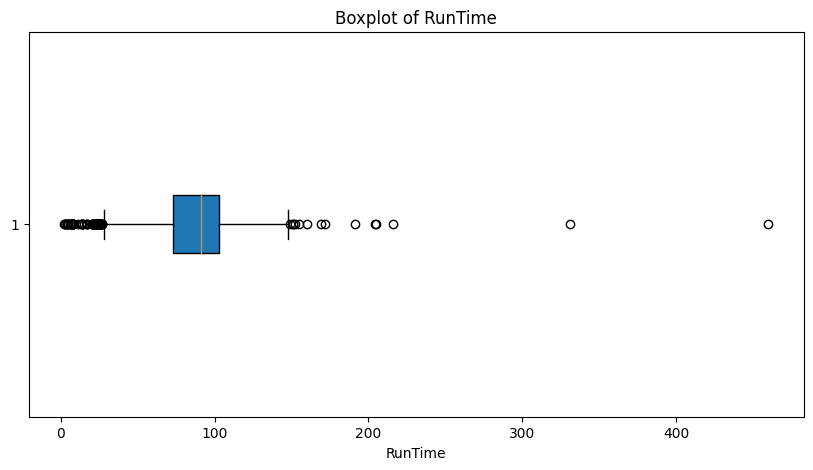

In [50]:
#We are not ending it here, let's look into the outliers for our Runtime column
#we are using boxplot to check outliers
movies_runtime = movies_df[movies_df['Type'] == 'Movie']
# movies_runtime
plt.figure(figsize=(10, 5))
plt.boxplot(movies_runtime['RunTime'], vert=False, patch_artist=True)
plt.title('Boxplot of RunTime')
plt.xlabel('RunTime')
plt.show()

In [51]:
movie_runt = movies_df[(movies_df['RunTime'] < 20) & (movies_df['Type'] == 'Movie')]
movie_runt

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,Type
246,As We Sleep,(2002),Unknown,7,Add a Plot,,21441,7,Elizabeth Mcdonald,Movie
261,Venus on the Halfshell,(2003),"Comedy, Romance",8,"Smart, young forest ranger marries handsome, f...","Monica Snow, Jonathan Aube, Jennifer Gareis, M...",40,7,Niels Nielsen,Movie
319,James,(2005),"Action, Romance",4,A story of a young man's quest to avenge the d...,"Mohit Ahlawat, Priyanka Kothari, Mohan Agashe,...",340,5,Rohit Jugraj,Movie
320,Tum... Ho Na!,(2005),Romance,5,"Tall, attractive Anajli, in the company of two...","Sumit Nijhawan, Nethra Raghuraman, Jackie Shro...",40,7,N.S. Raj Bharath,Movie
492,Suzumiya Haruhi chan no yûutsu,(2009),"Animation, Comedy",7,A parody of the original show. Based on the pa...,"Minori Chihara, Yûko Gotô, Aya Hirano, Tomokaz...",396,3,,Movie
...,...,...,...,...,...,...,...,...,...,...
5634,Troll,(2022),"Action, Adventure, Fantasy",7,"Deep in the Dovre mountain, something gigantic...",,21441,7,Roar Uthaug,Movie
5637,Loving Adults,(2022),Thriller,7,Follows a couple who appear to be living the p...,"Dar Salim, Lars Ranthe, Sonja Richter, Mikael ...",21441,7,Barbara Topsøe-Rothenborg,Movie
5640,Escape from Hat,(2022),"Animation, Adventure, Comedy",8,A desperate rabbit rallies an unexpected band ...,,58668,7,Mark Osborne,Movie
5678,The Monkey King,(2023),"Animation, Action, Adventure",7,An animated version of the mythical Chinese hero.,"BD Wong, Hoon Lee, Jimmy O. Yang, Bowen Yang",21441,5,Anthony Stacchi,Movie


In [52]:
#There may not have movies with less than 20 minutes so we are finding out mean grouping by Type of Movie
# Calculate the mean runtime for each movie type
mean_runtimes_by_type = movies_df.groupby('Type')['RunTime'].transform('mean')

# Replace runtimes less than 20 with the mean for that movie type
movies_df.loc[(movies_df['RunTime'] < 20) & (movies_df['Type'] == 'Movie'), 'RunTime'] = mean_runtimes_by_type
movies_df['RunTime'] = movies_df['RunTime'].round().astype(int)
movies_df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,Type
0,Söderkåkar,(1932),Comedy,5,The movie version of Gideon Wahlbergs comedy a...,"Gideon Wahlberg, Dagmar Ebbesen, Björn Berglun...",59,87,Weyler Hildebrand,Movie
1,Scarface,(1932),"Action, Crime, Drama",8,An ambitious and nearly insane violent gangste...,"Paul Muni, Ann Dvorak, Karen Morley, Osgood Pe...",26365,93,"Howard Hawks, Richard Rosson",Show
2,Kära släkten,(1933),Comedy,5,The story about a Stockholm wholesaler and his...,"Gösta Ekman, Tutta Rolf, Carl Barcklind, Thor ...",36,94,Gustaf Molander,Movie
3,Karriär,(1938),Drama,5,A traveling theater company in Sweden. Conflic...,"Signe Hasso, Sture Lagerwall, Tollie Zellman, ...",52,106,Schamyl Bauman,Show
4,Dumbo,(1941),"Animation, Adventure, Drama",7,"Ridiculed because of his enormous ears, a youn...","Sterling Holloway, Edward Brophy, Herman Bing,...",124409,64,"Samuel Armstrong, Norman Ferguson, Wilfred Jac...",Show
...,...,...,...,...,...,...,...,...,...,...
6004,Follow Me,(VI) (2018),Documentary,5,After hearing that some people get paid $5000 ...,,250,80,Asri Bendacha,Show
6005,Metamorphosis,(VI) (2019),Drama,7,Adam was raise like a normal boy until he bled...,"Gold Azeron, Iana Bernardez, Dylan Ray Talon, ...",40,98,J.E. Tiglao,Show
6006,Maestro,(VII),"Biography, Drama, Music",7,"The complex love of Leonard and Felicia, from ...","Bradley Cooper, Carey Mulligan, Jeremy Strong",21441,7,Bradley Cooper,Show
6007,Reborn,(VII),"Action, Adventure, Fantasy",7,Adaptation of the Millerworld comic book serie...,,21441,71,Chris McKay,Show


# Exploratory Data Analysis

### Highest Rating

In [53]:
top_10_movies = movies_df.sort_values(by='RATING', ascending=False).head(10)
# top_10_movies = movies_df.nlargest(10, 'RATING')
top_10_movies

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,Type
269,Arrested Development,(2003–2019),Comedy,9,Level-headed son Michael Bluth takes over fami...,"Jason Bateman, Michael Cera, Portia de Rossi, ...",284373,22,,Show
147,Friends,(1994–2004),"Comedy, Romance",9,Follows the personal and professional lives of...,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",880918,22,,Show
4527,Saikojiman Gwaenchanha,(2020),"Comedy, Drama, Romance",9,An extraordinary road to emotional healing ope...,"Kim Soo-hyun, Seo Ye-Ji, Oh Jeong-Se, Park Gyu...",14079,70,,Show
4085,When They See Us,(2019),"Biography, Crime, Drama",9,Five teens from Harlem become trapped in a nig...,"Asante Blackk, Caleel Harris, Ethan Herisse, M...",102201,296,,Show
5044,Booba: Food Puzzle,(2020– ),"Animation, Comedy, Family",9,"In a cozy kitchen, in the spotlight meet every...","Artem Kretov, Elena Solovieva, Roman Karev, El...",21,3,,Show
3601,Regiment Diaries,(2018–2019),Documentary,9,The Indian army is a family of several regimen...,,66,42,,Show
637,Downton Abbey,(2010–2015),"Drama, Romance",9,A chronicle of the lives of the British aristo...,"Hugh Bonneville, Phyllis Logan, Elizabeth McGo...",171804,58,,Show
5047,Emily's Wonder Lab,(2020– ),"Family, Talk-Show",9,Acclaimed science communicator Emily Calandrel...,"Emily Calandrelli, Arya Darbahani, Christopher...",147,0,,Show
3073,Tian sheng chang ge,(2018),"Drama, History, Romance",9,"The story of power, desire, lust and love amon...","Kun Chen, Hong Yuan, Ni Ni, Ou Wang",1311,60,,Show
4089,Our Planet,(2019),Documentary,9,Documentary series focusing on the breadth of ...,David Attenborough,36473,403,,Show


### Most Votes on Movies

In [54]:
new_df = movies_df.copy()
top_n_rows = new_df.nlargest(10, 'VOTES')
top_n_rows['VOTES'] = new_df['VOTES'].apply(lambda x: format(x, ','))
top_n_rows

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,Type
221,The Lord of the Rings: The Fellowship of the Ring,(2001),"Action, Adventure, Drama",9,A meek Hobbit from the Shire and eight compani...,"Elijah Wood, Ian McKellen, Orlando Bloom, Sean...","1,713,028",178,Peter Jackson,Show
259,The Lord of the Rings: The Return of the King,(2003),"Action, Adventure, Drama",9,Gandalf and Aragorn lead the World of Men agai...,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...","1,691,777",201,Peter Jackson,Show
476,Breaking Bad,(2008–2013),"Crime, Drama, Thriller",9,A high school chemistry teacher diagnosed with...,"Bryan Cranston, Aaron Paul, Anna Gunn, Betsy B...","1,552,311",49,,Show
245,The Lord of the Rings: The Two Towers,(2002),"Action, Adventure, Drama",9,While Frodo and Sam edge closer to Mordor with...,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...","1,529,752",179,Peter Jackson,Show
369,The Departed,(2006),"Crime, Drama, Thriller",8,An undercover cop and a mole in the police att...,"Leonardo DiCaprio, Matt Damon, Jack Nicholson,...","1,227,522",151,Martin Scorsese,Show
258,Kill Bill: Vol. 1,(2003),"Action, Crime, Drama",8,"After awakening from a four-year coma, a forme...","Uma Thurman, David Carradine, Daryl Hannah, Mi...","1,034,554",111,Quentin Tarantino,Show
132,Jurassic Park,(1993),"Action, Adventure, Sci-Fi",8,A pragmatic paleontologist visiting an almost ...,"Sam Neill, Laura Dern, Jeff Goldblum, Richard ...","897,444",127,Steven Spielberg,Movie
1358,Gone Girl,(2014),"Drama, Mystery, Thriller",8,With his wife's disappearance having become th...,"Ben Affleck, Rosamund Pike, Neil Patrick Harri...","895,888",149,David Fincher,Show
2179,Stranger Things,(2016– ),"Drama, Fantasy, Horror",9,"When a young boy disappears, his mother, a pol...","Millie Bobby Brown, Finn Wolfhard, Winona Ryde...","885,856",51,,Show
647,The Walking Dead,(2010–2022),"Drama, Horror, Thriller",8,Sheriff Deputy Rick Grimes wakes up from a com...,"Andrew Lincoln, Norman Reedus, Melissa McBride...","885,805",44,,Show


## Finding Most Rated Movies By Year

In [55]:
#Removing the leading or trailing spaces from the genre 
movies_df['GENRE'] = movies_df['GENRE'].str.strip()
#separting Genre cell by commas
unique_genres = movies_df['GENRE'].str.split(', ').explode()
genre_counts = unique_genres.value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']
genre_counts

,Genre,Count
0,Drama,2365
1,Comedy,1899
2,Action,1012
3,Documentary,940
4,Crime,815
5,Animation,790
6,Adventure,702
7,Romance,634
8,Thriller,581
9,Mystery,385


### Most Movies by Director

In [56]:
unique_genres = movies_df['DIRECTOR'].str.split(', ').explode()
director_counts = unique_genres.value_counts().reset_index()
director_counts.columns = ['DIRECTOR', 'Count']
director_counts = director_counts[director_counts['DIRECTOR'] != '']
director_counts.head()

,DIRECTOR,Count
1,Jay Karas,17
2,Marcus Raboy,15
3,Jan Suter,15
4,Raúl Campos,15
5,Jay Chapman,14


### Stars Appeared the Most

In [57]:
unique_genres = movies_df['STARS'].str.split(', ').explode()
stars_counts = unique_genres.value_counts().reset_index()
stars_counts.columns = ['STARS', 'Count']
stars_counts = stars_counts[stars_counts['STARS'] != '']
stars_counts.head()

,STARS,Count
1,Jakob Eklund,18
2,Johnny Yong Bosch,18
3,Kana Hanazawa,16
4,Adam Sandler,13
5,Ashleigh Ball,13


In [58]:
movies_df.isnull().sum()

MOVIES      0
YEAR        0
GENRE       0
RATING      0
ONE-LINE    0
STARS       0
VOTES       0
RunTime     0
DIRECTOR    0
Type        0
dtype: int64

In [59]:
#getting yearly highest rating movies
specific_year_data = movies_df[movies_df['YEAR'] == "(2020)"].sort_values(by='RATING', ascending=False).head(10)
specific_year_data

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,DIRECTOR,Type
4529,The Flower of Evil,(2020),"Crime, Mystery, Romance",9,"""Flower of Evil"" is a suspense melodrama about...","Lee Joon-Gi, Moon Chae-Won, Seo Hyun-woo, Choi...",4151,70,,Movie
4557,David Attenborough: A Life on Our Planet,(2020),"Documentary, Biography",9,One man has seen more of the natural world tha...,"David Attenborough, Max Hughes",28445,83,"Alastair Fothergill, Jonathan Hughes, Keith Sc...",Show
4839,Lenox Hill,(2020),Documentary,9,An intimate look at the lives of four doctors ...,"John Boockvar, David Langer, Amanda Little-Ric...",2044,48,,Show
4527,Saikojiman Gwaenchanha,(2020),"Comedy, Drama, Romance",9,An extraordinary road to emotional healing ope...,"Kim Soo-hyun, Seo Ye-Ji, Oh Jeong-Se, Park Gyu...",14079,70,,Show
4632,Sky Tour: The Movie,(2020),"Documentary, Music",9,"From the preparations to the performances, thi...",Son Tung Mtp,996,94,Son Tung Mtp,Show
4833,The Last Dance,(2020),"Documentary, Biography, History",9,"Charting the rise of the 1990's Chicago Bulls,...","Phil Jackson, Michael Jordan, David Aldridge, ...",93041,491,,Show
4481,Messiah,(2020),"Drama, Mystery, Thriller",8,"When a CIA officer investigates a man, and his...","Michelle Monaghan, Mehdi Dehbi, John Ortiz, To...",39729,43,,Show
4624,The Social Dilemma,(2020),"Documentary, Drama",8,Explores the dangerous human impact of social ...,"Tristan Harris, Jeff Seibert, Bailey Richardso...",72604,94,Jeff Orlowski,Show
4485,Hollywood,(2020),Drama,8,"After returning from the war, Jack Castello ar...","David Corenswet, Darren Criss, Laura Harrier, ...",1572,44,Ryan Murphy,Show
4533,Ssanggabpocha,(2020),"Comedy, Fantasy, Mystery",8,A young man with an unique ability begins work...,"Hwang Jeong-eum, Sung-Jae Yook, Choi Wonyoung,...",1414,70,,Movie


# Data Visualization

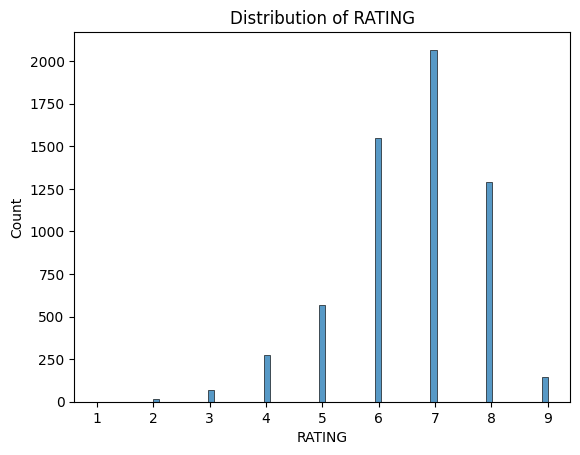

In [60]:
sns.histplot(movies_df['RATING'])
plt.xlabel('RATING')
plt.title('Distribution of RATING')
plt.show()

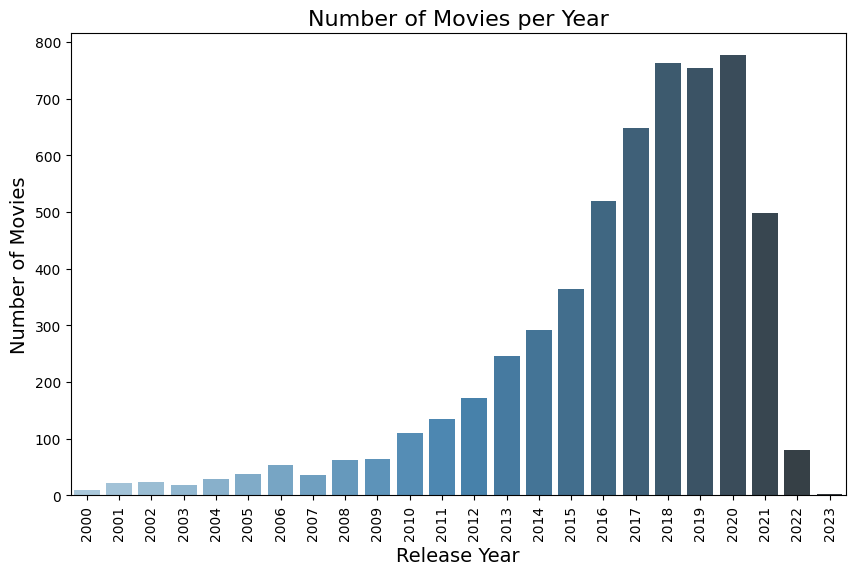

In [61]:
df_year = movies_df.copy()
df_year['RELEASE_YEAR_START'] = df_year['YEAR'].str.extract(r'(\d{4})')[0]
df_year['RELEASE_YEAR_END'] = df_year['YEAR'].str.extract(r'(\d{4})–(\d{4})')[1]

# Replacing NaN values in RELEASE_YEAR_START and RELEASE_YEAR_END with '0' (for movies with single years)
df_year['RELEASE_YEAR_START'].fillna('0', inplace=True)
df_year['RELEASE_YEAR_END'].fillna('0', inplace=True)

df_year = df_year[(df_year['RELEASE_YEAR_START'].astype(int) >= 2000) & (df_year['RELEASE_YEAR_END'].astype(int) <= 2023)]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_year, x='RELEASE_YEAR_START', palette='Blues_d')
plt.title('Number of Movies per Year', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=90)
plt.show()

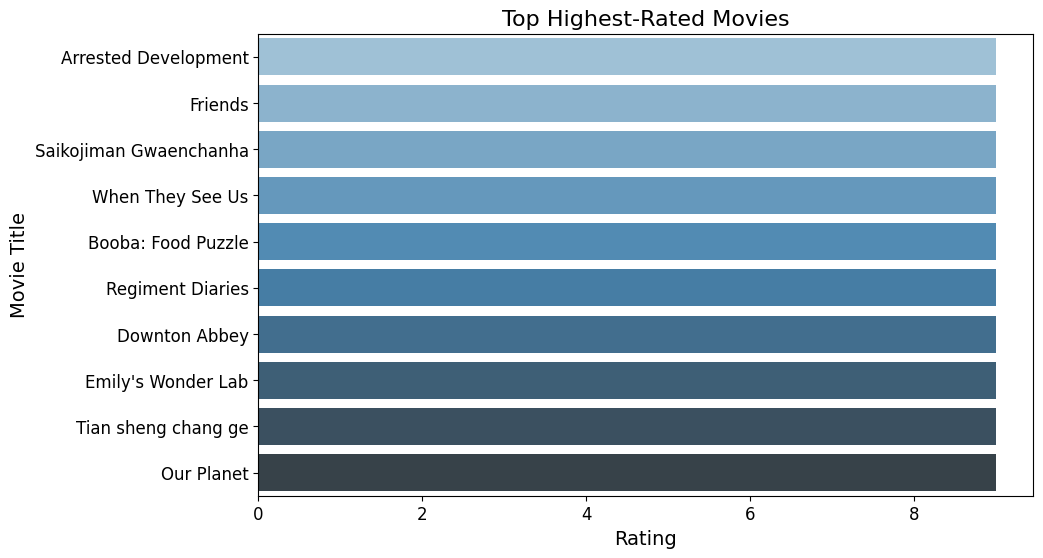

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_movies, x='RATING', y='MOVIES', palette='Blues_d')
plt.title(f'Top Highest-Rated Movies', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

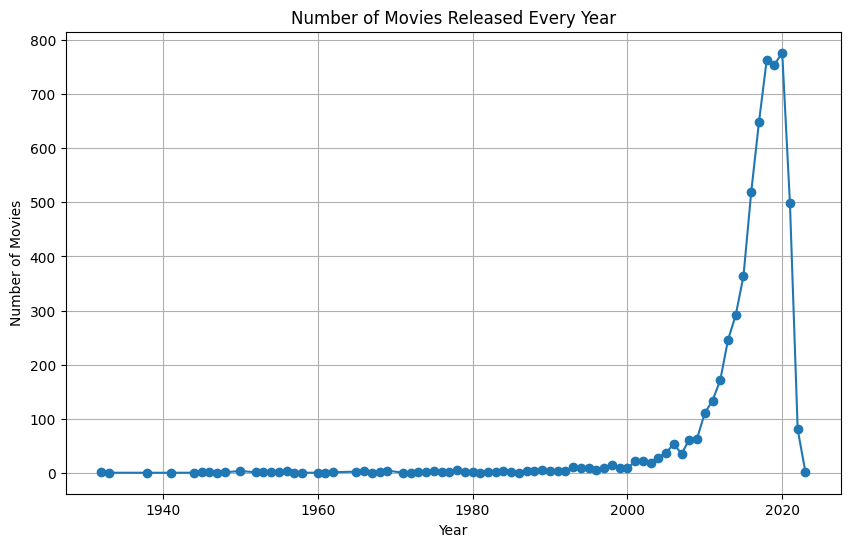

In [63]:
lineplot_df = movies_df.copy()

lineplot_df['YEAR'] = lineplot_df['YEAR'].str.extract(r'(\d{4})', expand=False)

# Convert years to integers
lineplot_df['YEAR'] = lineplot_df['YEAR'].astype(float).astype('Int64')

lineplot_df = lineplot_df[lineplot_df['YEAR'] <= 2023]

# Drop rows with missing years
lineplot_df = lineplot_df.dropna(subset=['YEAR'])

# Group by 'YEAR' and count the number of movies in each year
movies_per_year = lineplot_df['YEAR'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o')
plt.title('Number of Movies Released Every Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

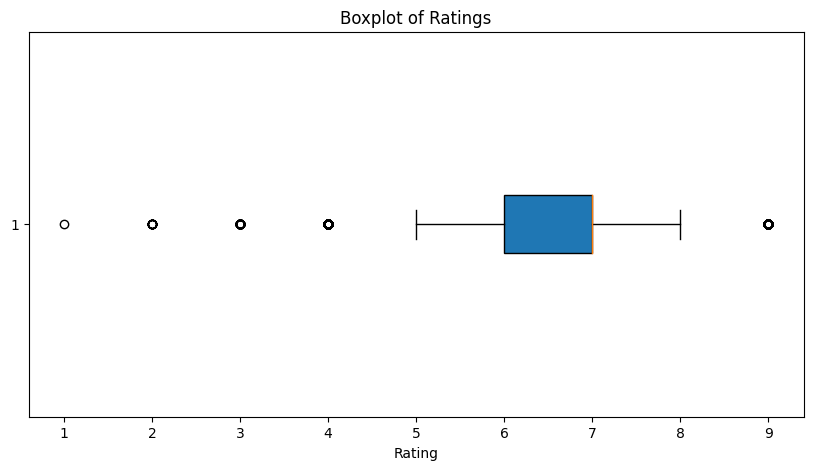

In [64]:
plt.figure(figsize=(10, 5))
plt.boxplot(movies_df['RATING'], vert=False, patch_artist=True)
plt.title('Boxplot of Ratings')
plt.xlabel('Rating')
plt.show()

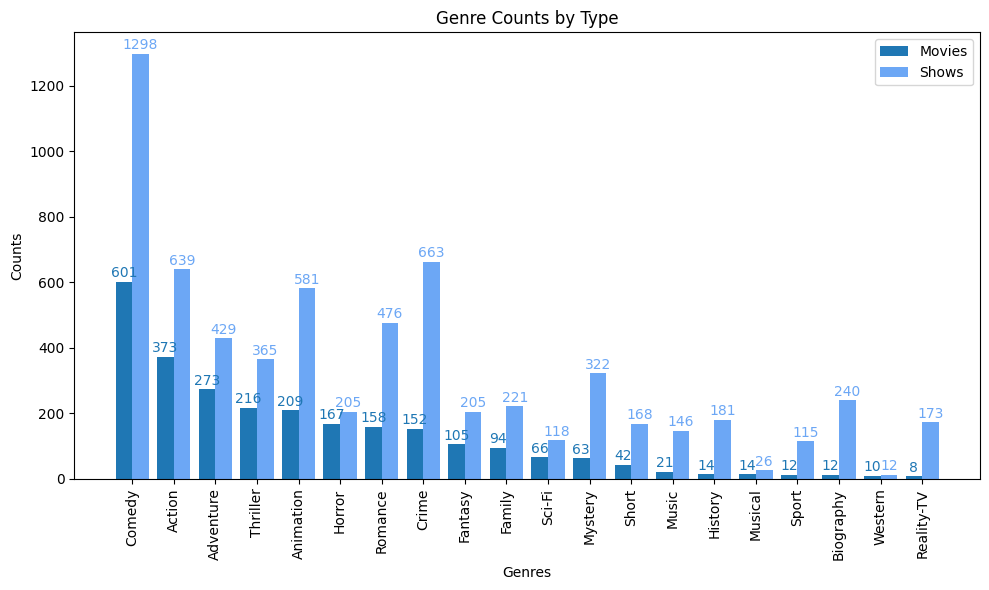

In [65]:
genre_counts_movies = movies_df[movies_df['Type'] == 'Movie']['GENRE'].str.split(',').explode().str.strip().value_counts()
genre_counts_shows = movies_df[movies_df['Type'] == 'Show']['GENRE'].str.split(',').explode().str.strip().value_counts()

top_genres = genre_counts_movies[:20].index

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.4

# Defining the position of the bars on the x-axis
index = range(len(top_genres))

dark_blue = '#1f77b4'
light_blue = '#6ca7f5'

# for movies
bars_movies = plt.bar(index, genre_counts_movies[top_genres], bar_width, color=dark_blue, label='Movies')

# for shows
bars_shows = plt.bar([p + bar_width for p in index], genre_counts_shows[top_genres], bar_width, color=light_blue, label='Shows')

# Adding labels, title, and custom x-axis tick labels
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.title('Genre Counts by Type')
plt.xticks([p + bar_width / 2 for p in index], top_genres, rotation=90)
plt.legend()

# Adding counts on top of the bars
for bar in bars_movies:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar_width/2, yval + 5, round(yval, 2), ha='center', va='bottom', color=dark_blue)

for bar in bars_shows:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar_width/2, yval + 5, round(yval, 2), ha='center', va='bottom', color=light_blue)

plt.tight_layout()
plt.show()

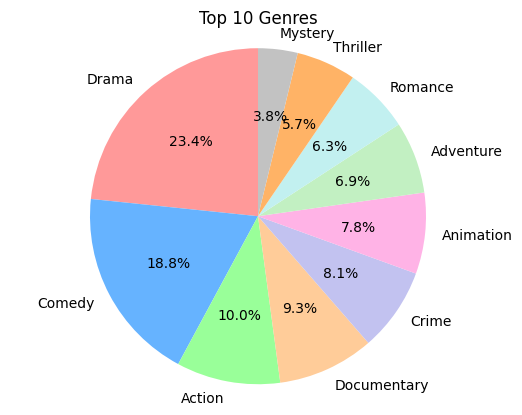

In [66]:
# type_counts = movies_df['Type'].value_counts()
# genre_counts = movies_df['GENRE'].str.split(',').explode().str.strip().value_counts()

# # Creating the figure and the outer pie chart
# fig, ax = plt.subplots()

# # Data for the outer pie chart
# ax.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=180, colors=['#66b3ff','#99ff99'])

# # To draw a white circle at the center
# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig.gca().add_artist(centre_circle)

# # Creating the subplot inside the pie chart
# sub_ax = fig.add_axes([0.3, 0.3, 0.4, 0.4])
# sub_ax.pie(genre_counts[:5], labels=genre_counts.index[:5], autopct='%1.1f%%', startangle=180, colors=['#ff9999','#66b3ff','#99ff99'])

# # Equal aspect ratio ensures that pie is drawn as a circle.
# ax.axis('equal')
# sub_ax.axis('equal')

# ax.set_title('Movies Analysis with the Type and Genre')
# plt.show()

top_genres = movies_df['GENRE'].str.split(',').explode().str.strip().value_counts()[:10]
fig, ax = plt.subplots()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c2f0c2', '#c2f0f0', '#ffb366', '#c2c2c2']
ax.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=90, colors=colors)
ax.axis('equal')

ax.set_title('Top 10 Genres')
plt.show()

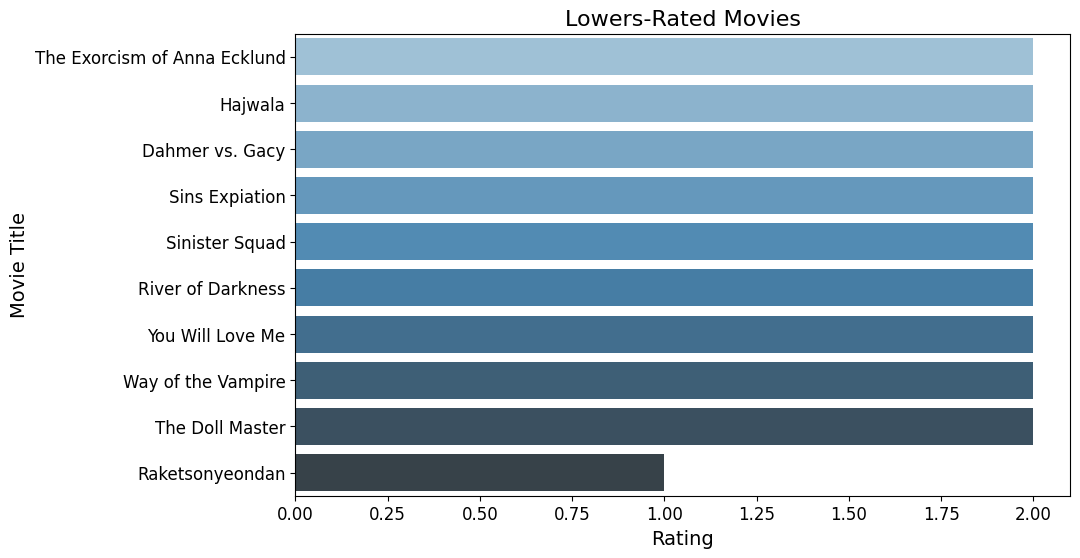

In [67]:
top_10_low_movies = movies_df.sort_values(by='RATING', ascending=False).tail(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_low_movies, x='RATING', y='MOVIES', palette='Blues_d')
plt.title(f'Lowers-Rated Movies', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

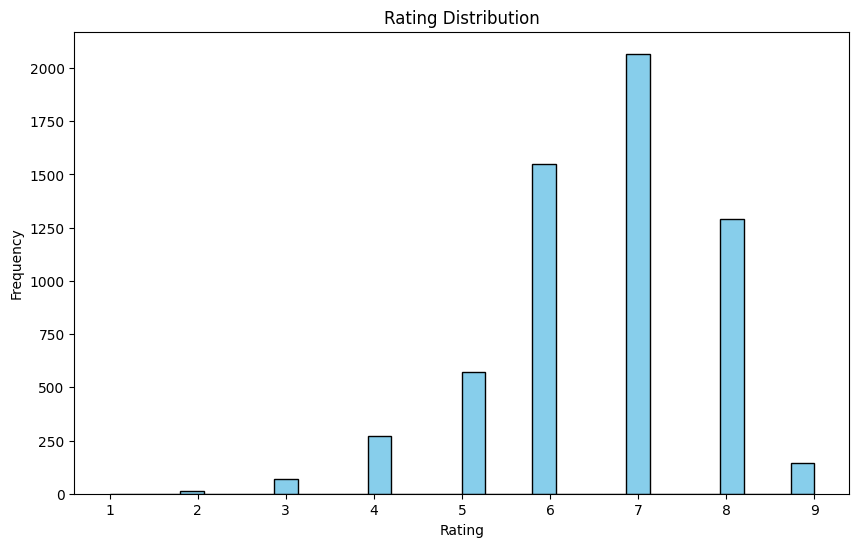

In [68]:
plt.figure(figsize=(10, 6))
plt.hist(movies_df['RATING'], bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')

plt.show()

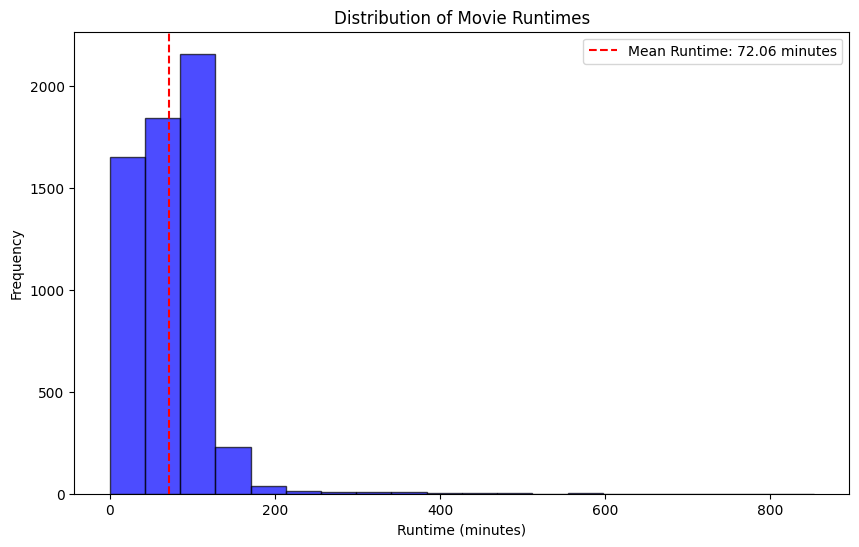

In [69]:
plt.figure(figsize=(10,6))
plt.hist(movies_df['RunTime'], bins=20, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')

# Adding a vertical line for the mean runtime
mean_runtime = movies_df['RunTime'].mean()
plt.axvline(x=mean_runtime, color='red', linestyle='--', label=f'Mean Runtime: {mean_runtime:.2f} minutes')
plt.legend()

plt.show()

<Axes: xlabel='Type', ylabel='RATING'>

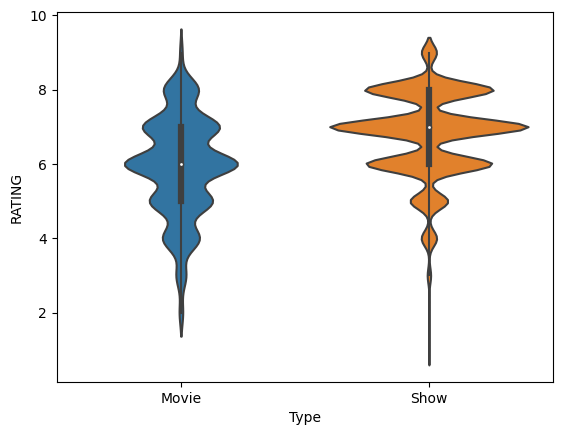

In [70]:
#testing out the violin plot
sns.violinplot(x='Type', y='RATING', data=movies_df)

In [71]:
numeric_df = movies_df[['RATING', 'RunTime', 'VOTES']]
cov_matrix = numeric_df.cov()
cov_matrix

,RATING,RunTime,VOTES
RATING,1.468245,-7.744022,1.714089e+04
RunTime,-7.744022,2350.275241,4.987260e+05
VOTES,17140.889622,498726.013601,6.682335e+09


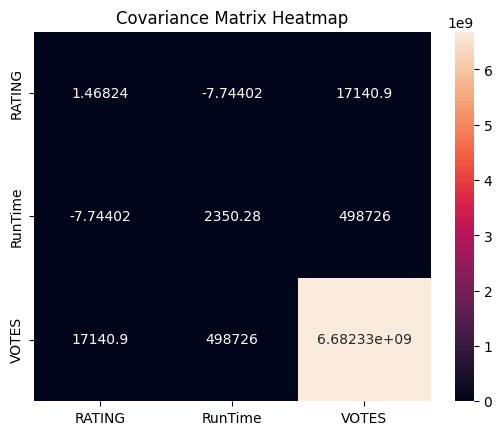

In [72]:
sns.heatmap(cov_matrix, annot=True, fmt='g')
plt.title('Covariance Matrix Heatmap')
plt.show()

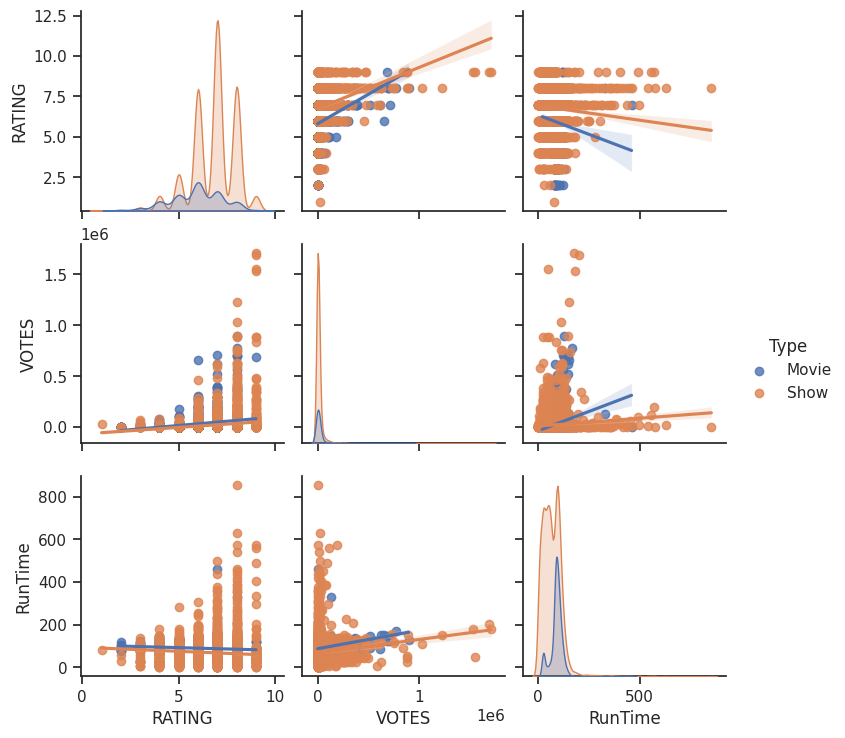

In [73]:
sns.set(style="ticks")
sns.pairplot(movies_df, hue='Type', kind='reg')

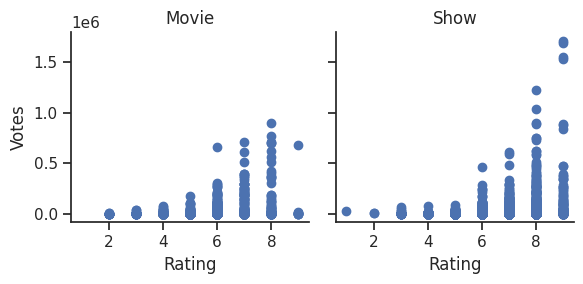

In [74]:
#FacetGrid trying out FacetGrid for the subplotting our RATING and VOTES
g = sns.FacetGrid(movies_df, col="Type")
g.map(plt.scatter, "RATING", "VOTES")
g.set_axis_labels("Rating", "Votes")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

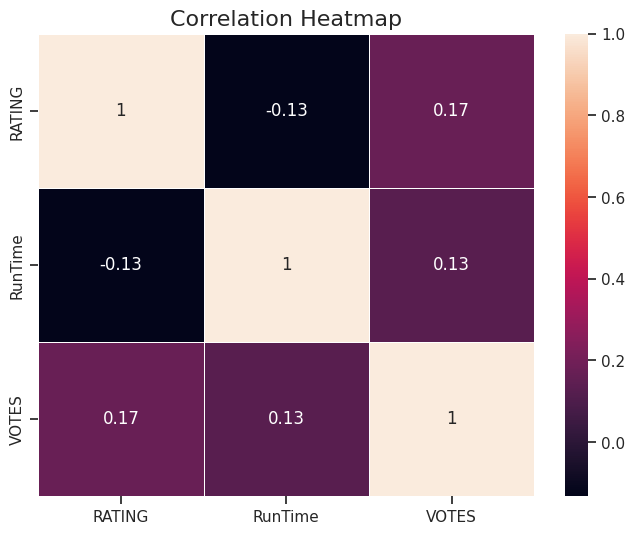

In [75]:
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()